# MNIST Hand-written Digit Images Classification

Environment Setup:

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Common imports
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

### Dataset info:

Author: Yann LeCun, Corinna Cortes, Christopher J.C. Burges

Source: [MNIST Website](http://yann.lecun.com/exdb/mnist/)

The MNIST database of handwritten digits with 784 features, and 70000 examples.

### Import data:

`fetch_openml` returns a Dictionary-like object, with:

- `data`: np.array, scipy.sparse.csr_matrix of floats, or pandas DataFrame
        
    * The feature matrix. 
    * Categorical features are encoded as ordinals.
        
- `target`: np.array, pandas Series or DataFrame
    * The regression target or classification labels, if applicable. 
    * Dtype is float if numeric, and object if categorical. 
    * If as_frame is True, target is a pandas object.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

In [3]:
print(f"The dataset contains {mnist.data.shape[0]} images; \nFor each image, there are {mnist.data.shape[1]} features.")

# visualize data
cols = [i for i in range(1,785)]
pd.DataFrame(mnist.data, columns=cols).head()

The dataset contains 70000 images; 
For each image, there are 784 features.


,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
print("For each image, it is labeled by a string indicating the digit it represents.")
pd.DataFrame(mnist.target, columns=["label"]).head()

For each image, it is labeled by a string indicating the digit it represents.


,label
0,5
1,0
2,4
3,1
4,9


### Preparation:

For this project, we focus on binary classification, which means, given a set of images, we want to determine whether the input image is digit $7$ or not. Therefore, we need to firstly transform the labels (`mnist.target`) into class 0 if the image is not $7$, and into class 1 otherwise:

In [5]:
digit_7 = []
for i in mnist['target']:
    if i == '7':
        digit_7.append(1)
    else:
        digit_7.append(0)
digit_7 = np.array(digit_7)
pd.DataFrame(digit_7, columns=["new_label"]).head()

,new_label
0,0
1,0
2,0
3,0
4,0


### Split dataset into 70-30 train-test:

In [6]:
X, y = mnist.data, digit_7

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state = 42)

### Hyper-parameter Tuning:

In this section, I will train several tree-based models (without early-stopping nor pruning for now) on the training set. For each model, I will use **5-fold cross validation** to find the optimal hyper-parameters, and store the optimal ones for further comparison. 

`scoring='neg_mean_squared_error'`: MSE is used for cross validation.
[scoring reference](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

In later stage of this project, we will compare optimal models by ROC, PR and F-1.

<div class="alert alert-block alert-info">
<b>Note:</b> Increasing the potential gird of parameters would increase our time cost, therefore we are not going to fine tuning each model in a super detailed way. What I am doing here is selecting some values based on sklearn documentation, my knowledge and understanding about the model, and other online sources. I would need to describe why I chose those certain parameters to tune and somehow explain the logic. </div>

#### Model 1: Gradient Boosting with 'deviance' (logistic regression) loss
- Save the optimal model 1 into `clf_gb_opt`
- `learning_rate`: float, default=0.1
    - Learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators.
- `n_estimators`: int, default=100
    - The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance. A larger n_trees decrease the bias. Best way is always to do GridSearchCV. But we can start from the point of diminishing return = around 50 trees 
- `max_depth`:int, default=3
    - The maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree. ***Tune this parameter for best performance;*** the best value depends on the interaction of the input variables, based on the number of observations and features. 

[Reference](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/)

In [7]:
from sklearn.model_selection import GridSearchCV

In [8]:
from sklearn.ensemble import GradientBoostingClassifier

# init the model
predictor = GradientBoostingClassifier(random_state=42)

# possible values of params
param_grid = [
    {
        'learning_rate':[0.02, 0.1],
        'n_estimators':[3, 10, 50],
        'max_depth': [1, 3, 5],
    },
  ]

# tune, and record the tuning time
import time
start_time = time.time()

grid_search = GridSearchCV(predictor, param_grid, cv=5,
                           scoring='neg_mean_squared_error', 
                           n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

# store the optimal model 1
clf_gb_opt = grid_search.best_estimator_

print("--- %s seconds ---" % (time.time() - start_time))

# print the optimal model 1
clf_gb_opt

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 41.2min finished
--- 2861.1666123867035 seconds ---


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

#### Model 2: AdaBoost (AdaBoostClassifier or Gradient Boosting with 'exponential' loss)
- Save the optimal model ``clf_ab_opt``.
- `base_estimator`: For AdaBoost, we can choose various weak learner as our `base_estimator`. In this notebook, we only consider the default 'None', which is a decision stump (DT with `max_depth` = 1)
- If we want to play with base_estimator, we can add components into the grid. For example, if we are using a DT, we can do the following:

        ```
        param_grid = [
                {
                        'base_estimator__criterion':["gini","entropy"],
                        'base_estimator__splitter' :["best", "random"],
                        'base_estimator__max_depth':[1,3,5]
                },
                        ]
        ```

- `random_state`: To obtain a deterministic behaviour during fitting, random_state has to be fixed to an integer.
- `learning rate`: The learning rate controls the loss function used for calculating the weight of the base models.
$$\text{Weight}=\text{learning rate}*log(\frac{1-e}{e})$$ where $e$ is the error. The learning rate depends highly upon `n_estimators`. By default, it is set to 1. It is common to use a smaller value of learning rate ranging between 0 and 1, like 0.1,0.001 because otherwise, it gives rise to the problem of overfitting.
- `n_estimator`: Generally, for a large number of n_estimators, we use a smaller value of learning rate. The number of trees added to the model must be high for the model to work well, often hundreds, if not thousands. Afterall the more is the number of weak learners, the more the model will change from being high biased to low biased. We often start from the turing point, the return diminishing point where n_estimator = 50.

[Reference](https://medium.com/@chaudhurysrijani/tuning-of-adaboost-with-computational-complexity-8727d01a9d20)

In [9]:
from sklearn.ensemble import AdaBoostClassifier
# from sklearn.tree import DecisionTreeClassifier
# DTC = DecisionTreeClassifier(random_state = 42)

predictor = AdaBoostClassifier(base_estimator = None, # None is default DT
                               random_state = 42)
param_grid = [
    {
        # 'base_estimator__criterion':["gini","entropy"],
        # 'base_estimator__splitter' :["best", "random"],
        # 'base_estimator__max_depth':[1,3,5]
        'n_estimators':[10, 50, 100],
        'learning_rate':[0.1, 0.5, 1.]
    },
  ]

import time
start_time = time.time()
grid_search = GridSearchCV(predictor, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))
clf_ab_opt = grid_search.best_estimator_
clf_ab_opt

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 21.0min finished
--- 1478.143543958664 seconds ---


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.5,
                   n_estimators=100, random_state=42)

In [10]:
clf_ab_opt.base_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

#### Model 3: Random Forest with ``gini`` criterion.
- Save the optimal model ``clf_rf1_opt``.
- `n_estimators`: The number of trees in the forest.
- `max_depth`: one important param that controls overfitting, default None is best often
- `max_features`: {‘auto’, ‘sqrt’, ‘log2’}, int or float, default=None
    - The number of features to consider when looking for the best split. In RF, we introduce more randomness than simply bagging. we restrict the num_of_features the trees are allowed to be built from. So each tree will be built from a random subset of not just rows (bootstrapping), but of a random subset of columns. For classification, we'll limit that subset of features/columns to the $\sqrt{\text{total number of features available}}$
    * If int, then consider max_features features at each split.
    * If float, then max_features is a fraction and int(max_features * n_features) features are considered at each split.
    * If ‘auto’, then max_features=sqrt(n_features).
    * If ‘sqrt’, then max_features=sqrt(n_features).
    * If ‘log2’, then max_features=log2(n_features).
    * If None, then max_features=n_features.
    * Choosing `max_features` < n_features leads to a reduction of variance and an increase in bias.

[Reference](https://scikit-learn.org/stable/modules/ensemble.html#forest)

In [11]:
from sklearn.ensemble import RandomForestClassifier

predictor = RandomForestClassifier(max_features='sqrt',
                                   n_jobs=-1, 
                                   random_state=42, 
                                   criterion='gini')
param_grid = [
    {
        'n_estimators':[50, 500, 1000],
        'max_depth':[5, 100, None],
    },
  ]

import time
start_time = time.time()
grid_search = GridSearchCV(predictor, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))
clf_rf1_opt = grid_search.best_estimator_
clf_rf1_opt

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 34.6min finished
--- 2147.747824192047 seconds ---


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

#### Model 4: Random Forest with ``entropy`` criterion
- Save the optimal model ``clf_rf2_opt``

In [12]:
from sklearn.ensemble import RandomForestClassifier

predictor = RandomForestClassifier(max_features='sqrt', 
                                    n_jobs=-1, random_state=42, 
                                   criterion='entropy')
param_grid = [
    {
        'n_estimators':[50, 500, 1000],
        'max_depth':[5, 100, None]
    },
  ]

import time
start_time = time.time()
grid_search = GridSearchCV(predictor, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))
clf_rf2_opt = grid_search.best_estimator_
clf_rf2_opt

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 25.7min finished
--- 1593.8526721000671 seconds ---


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=100, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Model 5: Stochastic Gradient Boosting (from sklearn Gradient Boosting with sub-sampling at the row, column and column per split levels
- Save the optimal model ``clf_sgb_opt``
- similar with GradientBoostClassifier
- `subsample`:float, default=1.0
    * The fraction of samples to be used for fitting the individual base learners. If smaller than 1.0 this results in Stochastic Gradient Boosting. subsample interacts with the parameter n_estimators. Choosing subsample < 1.0 leads to a reduction of variance and an increase in bias.

In [13]:
from sklearn.ensemble import GradientBoostingClassifier

predictor = GradientBoostingClassifier(random_state=42)
param_grid = [
    {
        'subsample':[0.1, 0.3, 0.6],
        'learning_rate':[0.02, 0.1],
        'n_estimators':[5, 100],
        # 'max_depth': [5, 100],
    },
  ]

import time
start_time = time.time()
grid_search = GridSearchCV(predictor, param_grid, cv=5,
                           scoring='neg_mean_squared_error', 
                           n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
clf_sgb_opt = grid_search.best_estimator_
print("--- %s seconds ---" % (time.time() - start_time))
# print the optimal model 1
clf_sgb_opt

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 23.9min finished
--- 1725.1104662418365 seconds ---


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=0.6, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Model 6: VotingClassifier combining 1-5

- Note:
    * **scikit-learn estimators in the ``VotingClassifier`` must support ``predict_proba`` method**
    * **``VotingClassifier`` does not support ``predict_proba`` method when ``voting = 'hard'``**

In [14]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[('GB', clf_gb_opt), ('AB', clf_ab_opt), 
                ('RF1', clf_rf1_opt), ('RF2', clf_rf2_opt),
                ('SGB', clf_sgb_opt)],
    # voting approach: hard/soft
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('GB',
                              GradientBoostingClassifier(ccp_alpha=0.0,
                                                         criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.1,
                                                         loss='deviance',
                                                         max_depth=5,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                              

#### Model 6: StackingClassifier


In [15]:
from sklearn.ensemble import StackingClassifier
stacking_clf = StackingClassifier(
    estimators=[('GB', clf_gb_opt), ('AB', clf_ab_opt), 
                ('RF1', clf_rf1_opt), ('RF2', clf_rf2_opt),
                ('SGB', clf_sgb_opt)],
    )
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=None,
                   estimators=[('GB',
                                GradientBoostingClassifier(ccp_alpha=0.0,
                                                           criterion='friedman_mse',
                                                           init=None,
                                                           learning_rate=0.1,
                                                           loss='deviance',
                                                           max_depth=5,
                                                           max_features=None,
                                                           max_leaf_nodes=None,
                                                           min_impurity_decrease=0.0,
                                                           min_impurity_split=None,
                                                           min_samples_leaf=1,
                                                           min_samples_s

### Evaluation metrics:

In practice, the error metrics that we would like to choose may depend on the specific objective of the question. 

- For example, when we are classifying patients, what we are mostly caring about is the chance that we can get really illed patients correctly, or the possibility that we classified actual positives as predicted positives. In this case, we want to emphasize *Recall*, the true positive rate. 

In this notebook, we are classifying hand-written images. The question can be any one including:

- Accuracy: the overall classifying Accuracy
- Recall: ability to identify 7 correctly among actual 7 
- Precision: among those predicted 7, how often it is 7
- Specificity: avoiding false, similar as Recall, ability to identify not-7 correcly among actual not-7s
- F1 Score: capture the tradeoff between Precision & Recall
For each of the trained optimal classifiers, we compute PR and ROC curves.

In [ ]:
# list of trained models
models = {'GradientBoosting': clf_gb_opt, 
          'AdaBoost': clf_ab_opt,
          'RF1': clf_rf1_opt,
          'RF2': clf_rf2_opt,
          'StochasticGB': clf_sgb_opt,
          'VC':voting_clf,
          'SC':stacking_clf
         }

### Accuracy:

To obtain Accuracy, we can directly predict classes/labels, like {0, 1}, on testing set to get the counts of each of TP, TN, FP and FN.

Accuracy is calculated by $$\frac{TP+TN}{\text{total number of predictions}}$$

It measures the proportion of predictions that our model gets correctly.

In [23]:
from sklearn.metrics import accuracy_score
accuracy_7 = {}
y_true = y_test
for mname in models.keys():
    y_pred = models[mname].predict(X_test)
    accuracy_7[mname] = accuracy_score(y_true, y_pred)
accuracy_7

{'GradientBoosting': 0.9878095238095238,
 'AdaBoost': 0.9802380952380952,
 'RF1': 0.9891904761904762,
 'RF2': 0.9898571428571429,
 'StochasticGB': 0.9851904761904762,
 'VC': 0.9887619047619047,
 'SC': 0.992}

In terms of Accuracy, all models work fine with StackingClassifier dominates others.

### ROC & PR Curves:

To visualize other metrics mentioned above, we can make (*probability*) predictions on our testingset, and plot with various probability thresholds to come up with two famous curves:
- For balanced dataset, ROC curve (or AUC score) is a good choice
- For unbalanced dataset, PR curve is prefered.

In this notebook, we do not have a specific concern, so we could evaluate any of above to see the predict power of our best model.

### ROC Curve:

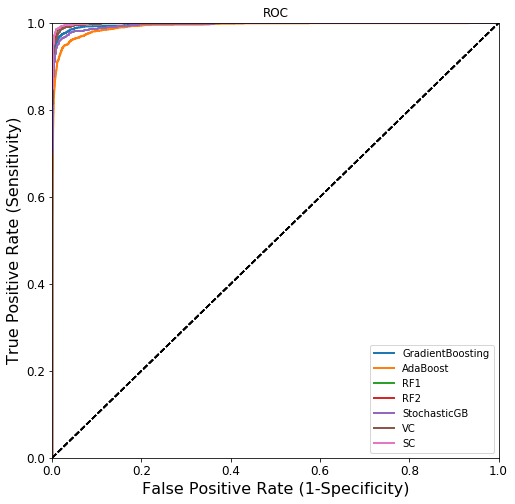

In [18]:
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve

def plot_roc_curve(ax, fpr, tpr, label=None):
    ax.plot(fpr, tpr, linewidth=2, label=label)
    if label is not None:
        ax.legend()
    ax.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (1-Specificity)', fontsize=16)
    plt.ylabel('True Positive Rate (Sensitivity)', fontsize=16)
    plt.title('ROC')
    
for i, mname in enumerate(models.keys()):
    probs = models[mname].predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    if i == 0:
        fig, ax = plt.subplots(1,1, figsize=(8,8))
    plot_roc_curve(ax, fpr, tpr, label=mname)
plt.show()

Bang! Nice performances!

In terms of ROC, we see that StackingClassifier dominates others. VotingClassifier and RFs come in the second place.

### PR Curves:

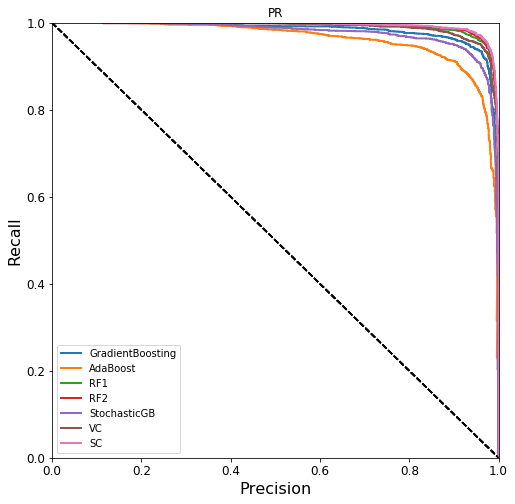

In [19]:
from sklearn.metrics import precision_recall_curve

def plot_pr_curve(ax, precision, recall, label=None):
    ax.plot(precision, recall, linewidth=2, label=label)
    if label is not None:
        ax.legend()
    ax.plot([0, 1], [1, 0], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Precision', fontsize=16)
    plt.ylabel('Recall', fontsize=16)
    plt.title('PR')

for i, mname in enumerate(models.keys()):
    probs = models[mname].predict_proba(X_test)
    preds = probs[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test, preds)

    if i == 0:
        fig, ax = plt.subplots(1,1, figsize=(8,8))
    plot_pr_curve(ax, precision, recall, label=mname)

plt.show()

StackingClassifer triple-kill!

In terms of PR, our StackingClassifer performs best again. Then, comes RFs. VotingClassifer, this time, loses its power compared with RFs.

### F-1 score:


In [20]:
from sklearn.metrics import f1_score

f1_7 = {}
y_true = y_test
for mname in models.keys():
    y_pred = models[mname].predict(X_test)
    f1_7[mname] = f1_score(y_true, y_pred)
f1_7

{'GradientBoosting': 0.9411223551057958,
 'AdaBoost': 0.904487917146145,
 'RF1': 0.9474658643832446,
 'RF2': 0.9509781357882623,
 'StochasticGB': 0.9283244987324268,
 'VC': 0.9455970493314894,
 'SC': 0.962059620596206}

StackingClassifier, one more time!

This makes sense when we look at the StackingClassifier's logic:

> Stacked generalization consists in stacking the output of individual estimator and use a classifier to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator.

Q1: why stacking beats individual ones?

- A1: stacking uses the output of individual models and again, as default setting, use LogisticRegression to make the final prediction. There is an improvements.

Q2: why stacking can beat another ensemble model -- Voting?

- A2: Voting is simply a (weighted) average of the results come from individual models, including some individual models, such as AdaBoost, whose predictive power is not impressive in this minist dataset. 



### Visualize some results:

- Select the overall best model using F-1 Score, and 
- Plot 4 images that the best classifier mislabels for the given digit

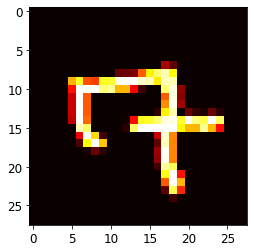

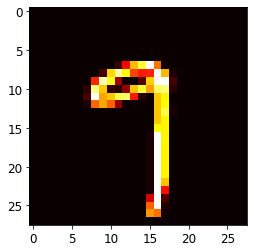

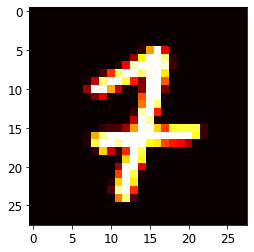

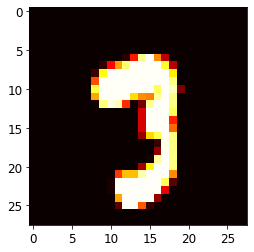

In [21]:
best_model_7 = models[max(f1_7, key=f1_7.get)]
y_pred = best_model_7.predict(X_test)
y_true = y_test

def plot_digit(data, label):
    pixels = np.array(data, dtype='uint8')
    image = pixels.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    
count = 4
for idx, (Xi, yi, yh) in enumerate(zip(X_test, y_true, y_pred)):
    if count == 0:
        break
    if yi != yh:
        plot_digit(Xi, label = 'image'+str(idx))
        plt.show()
        count-=1

Taking look at these 4 misclassified images. They are not showing our best model is not good enough, however. We are classifying digit 7, and we can see obvious noise among these four images. Even some of them are not $7$!! The problem may be caused during data collection, where some images are mis-labled. 

Given our best model has achieved a great performance, these noisy images can be put into our tolerence region. We can leave them for now, or deal with them mannually, by a detailed data preprocessing before training, or by a further analysis after classification. 

In short, although I came up several further works that I want to do in my future as in the cell below, my current best model works very well. 

### Further work: 

- After transforming into binary classes, the dataset actually is imbalanced with class 0 is much more larger than class 1. Re-sampling may improve the results.
- GridSearchCV: `scoring`
- Try RandomSearchCV
- Repeat all the works above for all other digits. For each digit, find the classifier that produces the best F1 score and plot 4 images that the classifier mislabels for the given digit. Comment on findings. (I wrapped this procedure in MNIST_Evaluator.ipynb)
- xgboost